In [ ]:
# Importando as bibliotecas necessárias
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

In [ ]:
# Download do dataset MNIST into data dir
! wget https://pjreddie.com/media/files/mnist_train.csv -P data

--2024-12-22 14:12:50--  https://pjreddie.com/media/files/mnist_train.csv
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109575994 (104M) [text/csv]
Saving to: ‘data/mnist_train.csv’

mnist_train.csv     100%[===================>] 104.50M  32.6MB/s    in 3.2s    

2024-12-22 14:12:54 (32.6 MB/s) - ‘data/mnist_train.csv’ saved [109575994/109575994]



In [ ]:
class MNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file, header=None)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # A primeira coluna é o rótulo
        label = self.data.iloc[idx, 0]
        # As demais colunas são os pixels da imagem
        image = self.data.iloc[idx, 1:].values.astype('uint8').reshape(28, 28)

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# Transformação para converter a imagem para tensor
transform = transforms.Compose([
    transforms.ToTensor(),      # Convertendo a imagem PIL para tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalizando a imagem
])

# Criando o dataset
mnist_dataset = MNISTDataset("./data/mnist_train.csv", transform=transform)

# Transformação para converter a imagem para tensor
transform = transforms.Compose([
    transforms.ToPILImage(),    # Convertendo o array numpy para imagem PIL
    transforms.ToTensor(),      # Convertendo a imagem PIL para tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalizando a imagem
])

# Criando o dataset
mnist_dataset = MNISTDataset("./data/mnist_train.csv", transform=transform)

In [ ]:
# Criando índices aleatórios para os subsets de treino e teste
np.random.seed(42)
indices = np.arange(len(mnist_dataset))
np.random.shuffle(indices)

# Dividindo os índices em trainset e testset
num_train = 1000
num_val = 500
num_test = 500
train_indices = indices[:num_train]  # Primeiros 1.000 índices para o trainset
val_indices = indices[num_train:num_train+num_val]  # Próximos 500 índices para o valset
test_indices = indices[num_train+num_val:num_train+num_val+num_test]  # Mais 500 para o testset

trainset = Subset(mnist_dataset, train_indices)
valset = Subset(mnist_dataset, val_indices)
testset = Subset(mnist_dataset, test_indices)

# Criando DataLoaders para os subsets
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

In [ ]:
def train_model(model, trainloader, valloader, criterion, optimizer, num_epochs=5):
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }

    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_acc)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%')

        # Validação
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct / total
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_acc)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.2f}%')

    print('Treinamento concluído')
    return history


def test_model(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')

In [ ]:
class CNN(nn.Module):
    def __init__(self, initialize_weights=True, dropout=0.2):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 12, 5)
        self.fc1 = nn.Linear(12 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(dropout)

        if initialize_weights:
            self._initialize_weights()

    def forward(self, x):
        # CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        # Flatten
        x = x.view(-1, 12 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

In [ ]:
model = CNN(
    initialize_weights=True,
    dropout=0.2
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
# Treinando a CNN
history = train_model(
    model=model,
    trainloader=trainloader,
    valloader=valloader,
    criterion=criterion,
    optimizer=optimizer
)

100%|██████████| 16/16 [00:01<00:00, 11.58it/s]


Epoch 1, Train Loss: 2.284, Train Accuracy: 15.00%
Epoch 1, Val Loss: 2.190, Val Accuracy: 31.20%


100%|██████████| 16/16 [00:01<00:00, 14.56it/s]


Epoch 2, Train Loss: 2.035, Train Accuracy: 37.50%
Epoch 2, Val Loss: 1.763, Val Accuracy: 49.40%


100%|██████████| 16/16 [00:00<00:00, 16.88it/s]


Epoch 3, Train Loss: 1.344, Train Accuracy: 59.10%
Epoch 3, Val Loss: 0.827, Val Accuracy: 74.20%


100%|██████████| 16/16 [00:00<00:00, 21.73it/s]


Epoch 4, Train Loss: 0.689, Train Accuracy: 77.30%
Epoch 4, Val Loss: 0.501, Val Accuracy: 85.80%


100%|██████████| 16/16 [00:00<00:00, 21.28it/s]


Epoch 5, Train Loss: 0.478, Train Accuracy: 84.20%
Epoch 5, Val Loss: 0.386, Val Accuracy: 88.60%
Treinamento concluído


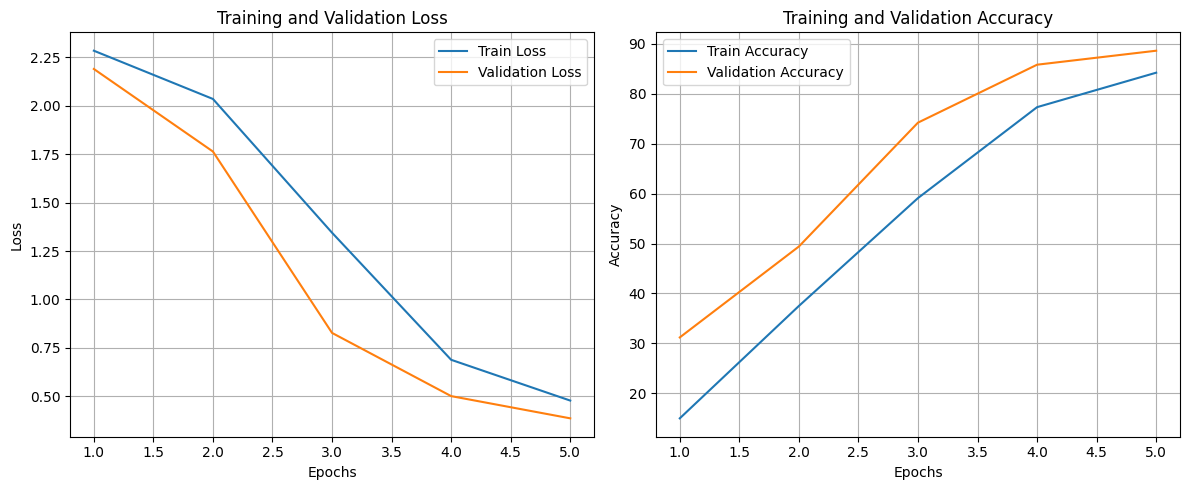

In [ ]:
epochs = range(1, len(history['train_losses']) + 1)

# Plot de losses
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.grid()
plt.plot(epochs, history['train_losses'], label='Train Loss')
plt.plot(epochs, history['val_losses'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot de accuracies
plt.subplot(1, 2, 2)
plt.grid()
plt.plot(epochs, history['train_accuracies'], label='Train Accuracy')
plt.plot(epochs, history['val_accuracies'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
test_model(model, testloader)

Acurácia da rede na base de teste: 89.00%


## Exercícios

### Exercício 1
Na CNN implementada, execute experimentos variando:
- O número de filtros convolucionais em `self.conv1` (6 e 8)
- O número de filtros convolucionais em `self.conv2` (12 e 16)

Ao final, observe qual combinação desempenha melhor no conjunto de testes.

Dica: Adicionar argumentos no construtor da classe para determinar o número de filtros em cada camada pode ser útil para inicializar diversos modelos.

In [ ]:
class CNN(nn.Module):
    def __init__(self, conv1_filters=6, conv2_filters=12, initialize_weights=True, dropout=0.2):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, conv1_filters, 5)  # Número de filtros ajustável
        self.conv2 = nn.Conv2d(conv1_filters, conv2_filters, 5)  # Número de filtros ajustável
        self.fc1 = nn.Linear(conv2_filters * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(dropout)

        if initialize_weights:
            self._initialize_weights()

    def forward(self, x):
        # CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        # Flatten
        x = x.view(-1, self.fc1.in_features)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)


In [ ]:
# Combinações de filtros
combinacoes = [(6, 12), (6, 16), (8, 12), (8, 16)]

# Loop para treinar e avaliar diferentes combinações
for conv1_filters, conv2_filters in combinacoes:
    print(f"Treinando modelo com conv1_filters={conv1_filters}, conv2_filters={conv2_filters}")

    # Inicialize o modelo com os filtros desejados
    modelo = CNN(conv1_filters=conv1_filters, conv2_filters=conv2_filters)

    #model = CNN(
#    initialize_weights=True,
#    dropout=0.2
#)


    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    # Treinando a CNN
    history = train_model(
        model=model,
        trainloader=trainloader,
        valloader=valloader,
        criterion=criterion,
        optimizer=optimizer
    )


Treinando modelo com conv1_filters=6, conv2_filters=12


100%|██████████| 16/16 [00:00<00:00, 16.44it/s]


Epoch 1, Train Loss: 0.171, Train Accuracy: 93.90%
Epoch 1, Val Loss: 0.315, Val Accuracy: 91.40%


100%|██████████| 16/16 [00:01<00:00, 14.81it/s]


Epoch 2, Train Loss: 0.166, Train Accuracy: 94.40%
Epoch 2, Val Loss: 0.324, Val Accuracy: 91.00%


100%|██████████| 16/16 [00:01<00:00, 14.50it/s]


Epoch 3, Train Loss: 0.146, Train Accuracy: 95.50%
Epoch 3, Val Loss: 0.310, Val Accuracy: 91.00%


100%|██████████| 16/16 [00:00<00:00, 20.85it/s]


Epoch 4, Train Loss: 0.115, Train Accuracy: 96.00%
Epoch 4, Val Loss: 0.309, Val Accuracy: 91.80%


100%|██████████| 16/16 [00:01<00:00, 15.66it/s]


Epoch 5, Train Loss: 0.132, Train Accuracy: 95.80%
Epoch 5, Val Loss: 0.308, Val Accuracy: 91.60%
Treinamento concluído
Treinando modelo com conv1_filters=6, conv2_filters=16


100%|██████████| 16/16 [00:00<00:00, 16.03it/s]


Epoch 1, Train Loss: 0.094, Train Accuracy: 96.70%
Epoch 1, Val Loss: 0.330, Val Accuracy: 91.80%


100%|██████████| 16/16 [00:00<00:00, 20.67it/s]


Epoch 2, Train Loss: 0.118, Train Accuracy: 95.30%
Epoch 2, Val Loss: 0.283, Val Accuracy: 92.80%


100%|██████████| 16/16 [00:00<00:00, 21.49it/s]


Epoch 3, Train Loss: 0.105, Train Accuracy: 96.60%
Epoch 3, Val Loss: 0.294, Val Accuracy: 92.60%


100%|██████████| 16/16 [00:00<00:00, 21.78it/s]


Epoch 4, Train Loss: 0.094, Train Accuracy: 97.20%
Epoch 4, Val Loss: 0.306, Val Accuracy: 92.60%


100%|██████████| 16/16 [00:00<00:00, 21.73it/s]


Epoch 5, Train Loss: 0.082, Train Accuracy: 97.40%
Epoch 5, Val Loss: 0.303, Val Accuracy: 92.20%
Treinamento concluído
Treinando modelo com conv1_filters=8, conv2_filters=12


100%|██████████| 16/16 [00:00<00:00, 21.22it/s]


Epoch 1, Train Loss: 0.068, Train Accuracy: 97.70%
Epoch 1, Val Loss: 0.327, Val Accuracy: 91.60%


100%|██████████| 16/16 [00:00<00:00, 19.16it/s]


Epoch 2, Train Loss: 0.061, Train Accuracy: 98.30%
Epoch 2, Val Loss: 0.275, Val Accuracy: 93.60%


100%|██████████| 16/16 [00:01<00:00, 15.45it/s]


Epoch 3, Train Loss: 0.063, Train Accuracy: 98.40%
Epoch 3, Val Loss: 0.292, Val Accuracy: 92.60%


100%|██████████| 16/16 [00:01<00:00, 14.77it/s]


Epoch 4, Train Loss: 0.064, Train Accuracy: 98.20%
Epoch 4, Val Loss: 0.322, Val Accuracy: 93.00%


100%|██████████| 16/16 [00:00<00:00, 19.78it/s]


Epoch 5, Train Loss: 0.061, Train Accuracy: 98.10%
Epoch 5, Val Loss: 0.305, Val Accuracy: 92.40%
Treinamento concluído
Treinando modelo com conv1_filters=8, conv2_filters=16


100%|██████████| 16/16 [00:01<00:00, 14.45it/s]


Epoch 1, Train Loss: 0.055, Train Accuracy: 98.10%
Epoch 1, Val Loss: 0.292, Val Accuracy: 93.00%


100%|██████████| 16/16 [00:00<00:00, 21.06it/s]


Epoch 2, Train Loss: 0.043, Train Accuracy: 98.80%
Epoch 2, Val Loss: 0.307, Val Accuracy: 93.40%


100%|██████████| 16/16 [00:00<00:00, 21.10it/s]


Epoch 3, Train Loss: 0.038, Train Accuracy: 99.00%
Epoch 3, Val Loss: 0.326, Val Accuracy: 93.20%


100%|██████████| 16/16 [00:00<00:00, 20.58it/s]


Epoch 4, Train Loss: 0.052, Train Accuracy: 98.30%
Epoch 4, Val Loss: 0.335, Val Accuracy: 92.60%


100%|██████████| 16/16 [00:00<00:00, 20.78it/s]


Epoch 5, Train Loss: 0.047, Train Accuracy: 98.30%
Epoch 5, Val Loss: 0.323, Val Accuracy: 93.00%
Treinamento concluído


In [ ]:
test_model(model, testloader)

Acurácia da rede na base de teste: 94.00%



Treinando modelo com conv1_filters=6, conv2_filters=12



100%|██████████| 16/16 [00:00<00:00, 21.65it/s]


Epoch 1, Train Loss: 0.034, Train Accuracy: 99.10%
Epoch 1, Val Loss: 0.317, Val Accuracy: 93.00%


100%|██████████| 16/16 [00:01<00:00, 14.11it/s]


Epoch 2, Train Loss: 0.029, Train Accuracy: 99.30%
Epoch 2, Val Loss: 0.324, Val Accuracy: 92.80%


100%|██████████| 16/16 [00:01<00:00, 15.55it/s]


Epoch 3, Train Loss: 0.030, Train Accuracy: 99.30%
Epoch 3, Val Loss: 0.332, Val Accuracy: 93.00%


100%|██████████| 16/16 [00:00<00:00, 21.41it/s]


Epoch 4, Train Loss: 0.041, Train Accuracy: 99.20%
Epoch 4, Val Loss: 0.322, Val Accuracy: 93.20%


100%|██████████| 16/16 [00:00<00:00, 21.67it/s]


Epoch 5, Train Loss: 0.022, Train Accuracy: 99.70%
Epoch 5, Val Loss: 0.299, Val Accuracy: 93.00%
Treinamento concluído


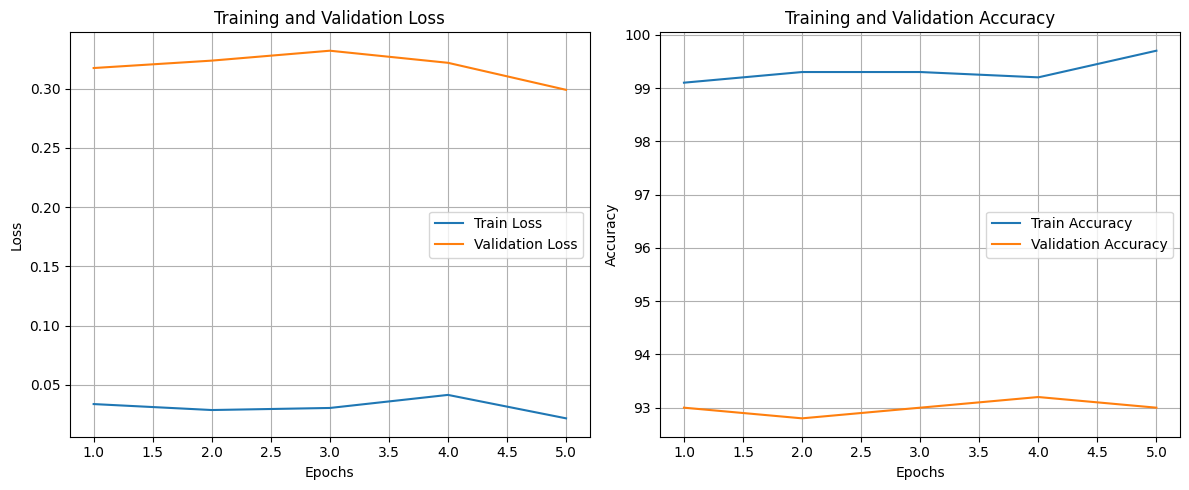


Treinando modelo com conv1_filters=6, conv2_filters=16



100%|██████████| 16/16 [00:00<00:00, 20.66it/s]


Epoch 1, Train Loss: 0.035, Train Accuracy: 99.10%
Epoch 1, Val Loss: 0.309, Val Accuracy: 93.40%


100%|██████████| 16/16 [00:00<00:00, 21.17it/s]


Epoch 2, Train Loss: 0.030, Train Accuracy: 99.00%
Epoch 2, Val Loss: 0.312, Val Accuracy: 93.00%


100%|██████████| 16/16 [00:00<00:00, 18.44it/s]


Epoch 3, Train Loss: 0.037, Train Accuracy: 99.00%
Epoch 3, Val Loss: 0.313, Val Accuracy: 93.80%


100%|██████████| 16/16 [00:01<00:00, 15.72it/s]


Epoch 4, Train Loss: 0.029, Train Accuracy: 99.20%
Epoch 4, Val Loss: 0.335, Val Accuracy: 93.80%


100%|██████████| 16/16 [00:01<00:00, 14.40it/s]


Epoch 5, Train Loss: 0.029, Train Accuracy: 99.30%
Epoch 5, Val Loss: 0.307, Val Accuracy: 93.40%
Treinamento concluído


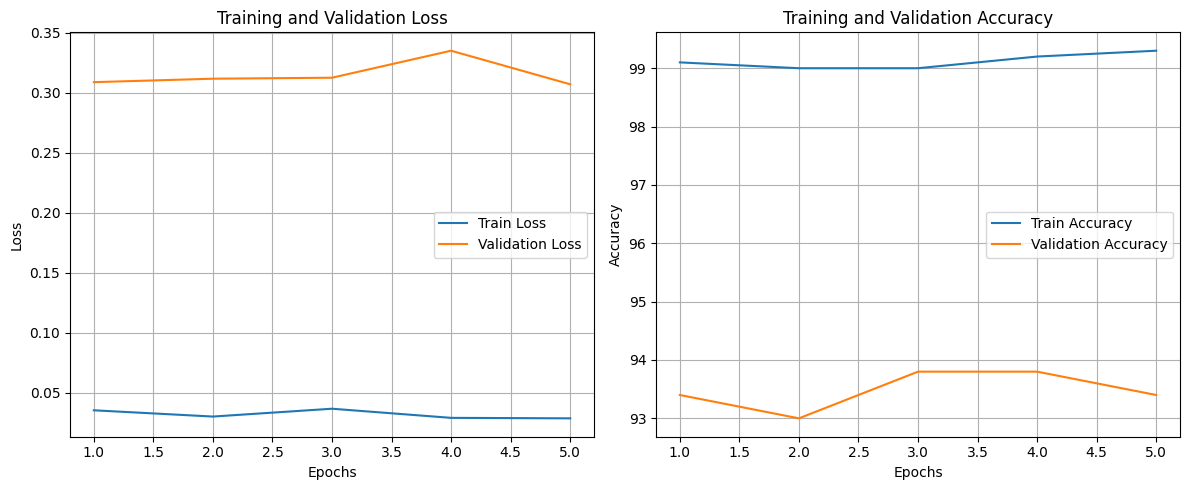


Treinando modelo com conv1_filters=8, conv2_filters=12



100%|██████████| 16/16 [00:00<00:00, 20.48it/s]


Epoch 1, Train Loss: 0.025, Train Accuracy: 99.50%
Epoch 1, Val Loss: 0.337, Val Accuracy: 93.60%


100%|██████████| 16/16 [00:00<00:00, 21.04it/s]


Epoch 2, Train Loss: 0.019, Train Accuracy: 99.70%
Epoch 2, Val Loss: 0.353, Val Accuracy: 93.00%


100%|██████████| 16/16 [00:00<00:00, 20.90it/s]


Epoch 3, Train Loss: 0.030, Train Accuracy: 98.90%
Epoch 3, Val Loss: 0.340, Val Accuracy: 92.60%


100%|██████████| 16/16 [00:00<00:00, 20.91it/s]


Epoch 4, Train Loss: 0.023, Train Accuracy: 99.10%
Epoch 4, Val Loss: 0.340, Val Accuracy: 92.60%


100%|██████████| 16/16 [00:00<00:00, 20.72it/s]


Epoch 5, Train Loss: 0.033, Train Accuracy: 99.10%
Epoch 5, Val Loss: 0.310, Val Accuracy: 92.80%
Treinamento concluído


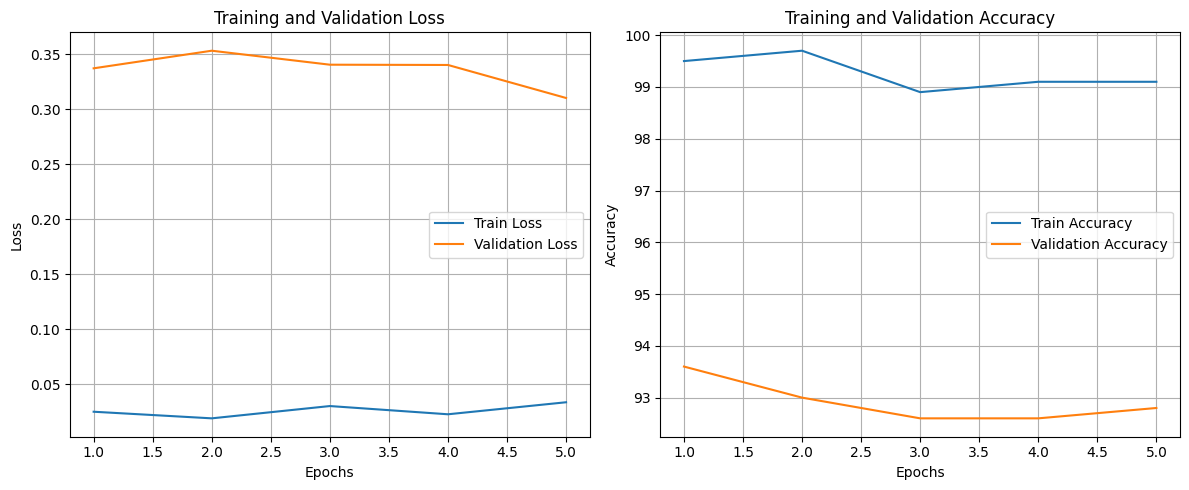


Treinando modelo com conv1_filters=8, conv2_filters=16



100%|██████████| 16/16 [00:00<00:00, 20.93it/s]


Epoch 1, Train Loss: 0.019, Train Accuracy: 99.60%
Epoch 1, Val Loss: 0.340, Val Accuracy: 93.00%


100%|██████████| 16/16 [00:00<00:00, 21.39it/s]


Epoch 2, Train Loss: 0.028, Train Accuracy: 98.90%
Epoch 2, Val Loss: 0.332, Val Accuracy: 92.00%


100%|██████████| 16/16 [00:00<00:00, 20.89it/s]


Epoch 3, Train Loss: 0.031, Train Accuracy: 99.00%
Epoch 3, Val Loss: 0.350, Val Accuracy: 91.60%


100%|██████████| 16/16 [00:01<00:00, 15.38it/s]


Epoch 4, Train Loss: 0.025, Train Accuracy: 99.40%
Epoch 4, Val Loss: 0.342, Val Accuracy: 93.20%


100%|██████████| 16/16 [00:01<00:00, 15.42it/s]


Epoch 5, Train Loss: 0.021, Train Accuracy: 99.50%
Epoch 5, Val Loss: 0.318, Val Accuracy: 93.80%
Treinamento concluído


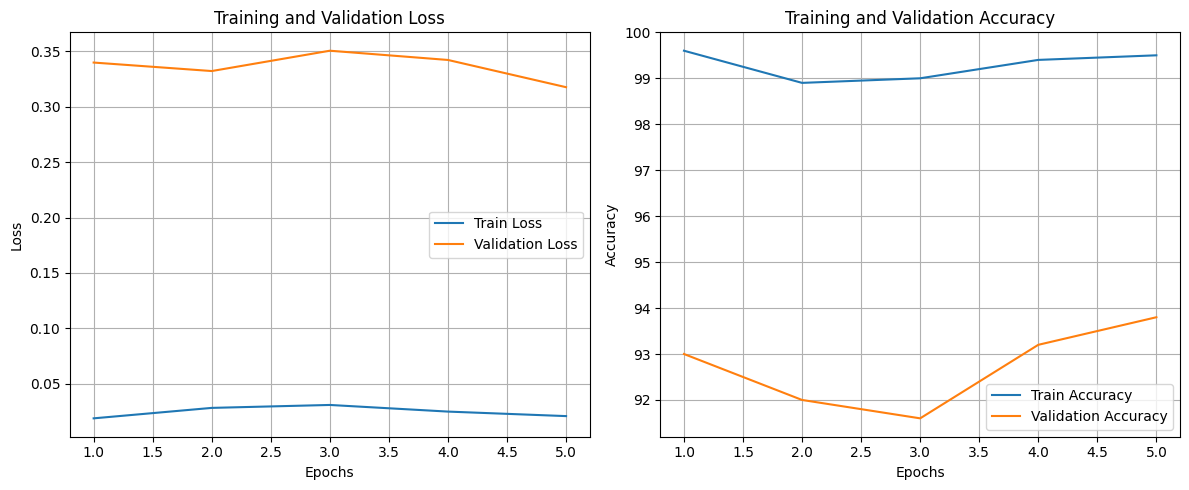

In [ ]:
# Combinações de filtros
combinacoes = [(6, 12), (6, 16), (8, 12), (8, 16)]

# Loop para treinar e avaliar diferentes combinações
for conv1_filters, conv2_filters in combinacoes:
    print()
    print(f"Treinando modelo com conv1_filters={conv1_filters}, conv2_filters={conv2_filters}")
    print()
    # Inicialize o modelo com os filtros desejados
    modelo = CNN(conv1_filters=conv1_filters, conv2_filters=conv2_filters)

    #model = CNN(
#    initialize_weights=True,
#    dropout=0.2
#)


    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    # Treinando a CNN
    history = train_model(
        model=model,
        trainloader=trainloader,
        valloader=valloader,
        criterion=criterion,
        optimizer=optimizer
    )

    epochs = range(1, len(history['train_losses']) + 1)

    # Plot de losses
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.grid()
    plt.plot(epochs, history['train_losses'], label='Train Loss')
    plt.plot(epochs, history['val_losses'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot de accuracies
    plt.subplot(1, 2, 2)
    plt.grid()
    plt.plot(epochs, history['train_accuracies'], label='Train Accuracy')
    plt.plot(epochs, history['val_accuracies'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

Apesar da acurácia de teste ter subido os gráficos indicam que há overfitting por que a acurácia do treino está muito acima do de teste.

### Exercício 2

Na CNN implementada, execute 5 treinamentos variando aleatoriamente o número de neurônios de saída em `self.fc1` (o valor atual é 64 e também deve ser alterado na entrada da próxima camada).

Como você determinaria qual foi o melhor valor?

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_neurons=64, conv1_filters=6, conv2_filters=12, initialize_weights=True, dropout=0.2):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, conv1_filters, 5)  # Número de filtros ajustável
        self.conv2 = nn.Conv2d(conv1_filters, conv2_filters, 5)  # Número de filtros ajustável
        self.fc1 = nn.Linear(conv2_filters * 4 * 4, num_neurons)
        self.fc2 = nn.Linear(num_neurons, 10)
        self.dropout = nn.Dropout(dropout)

        if initialize_weights:
            self._initialize_weights()

    def forward(self, x):
        # CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        # Flatten
        x = x.view(-1, self.fc1.in_features)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)


In [ ]:
for i in range(5):
    num_neurons = np.random.randint(10, 100)
    model = CNN(num_neurons= num_neurons, conv1_filters=conv1_filters, conv2_filters=conv2_filters)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    history = train_model(model=model, trainloader=trainloader, valloader=valloader, criterion=criterion, optimizer=optimizer)
    print()

    print(f'Número de neurônios na camada fully connected: {num_neurons}')
    test_model(model, testloader)
    print()

100%|██████████| 16/16 [00:00<00:00, 20.12it/s]


Epoch 1, Train Loss: 2.295, Train Accuracy: 14.80%
Epoch 1, Val Loss: 2.200, Val Accuracy: 15.80%


100%|██████████| 16/16 [00:00<00:00, 20.01it/s]


Epoch 2, Train Loss: 1.989, Train Accuracy: 36.60%
Epoch 2, Val Loss: 1.567, Val Accuracy: 52.20%


100%|██████████| 16/16 [00:00<00:00, 19.41it/s]


Epoch 3, Train Loss: 1.366, Train Accuracy: 51.70%
Epoch 3, Val Loss: 0.915, Val Accuracy: 72.40%


100%|██████████| 16/16 [00:01<00:00, 12.24it/s]


Epoch 4, Train Loss: 0.924, Train Accuracy: 66.70%
Epoch 4, Val Loss: 0.638, Val Accuracy: 79.80%


100%|██████████| 16/16 [00:00<00:00, 18.25it/s]


Epoch 5, Train Loss: 0.661, Train Accuracy: 76.80%
Epoch 5, Val Loss: 0.507, Val Accuracy: 85.00%
Treinamento concluído

Número de neurônios na camada fully connected: 55
Acurácia da rede na base de teste: 85.40%



100%|██████████| 16/16 [00:01<00:00, 15.00it/s]


Epoch 1, Train Loss: 2.278, Train Accuracy: 15.80%
Epoch 1, Val Loss: 2.194, Val Accuracy: 24.80%


100%|██████████| 16/16 [00:01<00:00, 14.09it/s]


Epoch 2, Train Loss: 2.077, Train Accuracy: 27.30%
Epoch 2, Val Loss: 1.761, Val Accuracy: 53.00%


100%|██████████| 16/16 [00:00<00:00, 20.80it/s]


Epoch 3, Train Loss: 1.357, Train Accuracy: 57.90%
Epoch 3, Val Loss: 0.750, Val Accuracy: 77.00%


100%|██████████| 16/16 [00:00<00:00, 20.96it/s]


Epoch 4, Train Loss: 0.687, Train Accuracy: 76.60%
Epoch 4, Val Loss: 0.485, Val Accuracy: 85.20%


100%|██████████| 16/16 [00:00<00:00, 20.61it/s]


Epoch 5, Train Loss: 0.454, Train Accuracy: 84.90%
Epoch 5, Val Loss: 0.403, Val Accuracy: 87.20%
Treinamento concluído

Número de neurônios na camada fully connected: 78
Acurácia da rede na base de teste: 91.20%



100%|██████████| 16/16 [00:00<00:00, 20.15it/s]


Epoch 1, Train Loss: 2.254, Train Accuracy: 19.30%
Epoch 1, Val Loss: 2.161, Val Accuracy: 38.00%


100%|██████████| 16/16 [00:00<00:00, 20.27it/s]


Epoch 2, Train Loss: 1.907, Train Accuracy: 44.90%
Epoch 2, Val Loss: 1.418, Val Accuracy: 67.60%


100%|██████████| 16/16 [00:00<00:00, 20.13it/s]


Epoch 3, Train Loss: 1.024, Train Accuracy: 67.50%
Epoch 3, Val Loss: 0.648, Val Accuracy: 78.00%


100%|██████████| 16/16 [00:00<00:00, 20.43it/s]


Epoch 4, Train Loss: 0.573, Train Accuracy: 80.30%
Epoch 4, Val Loss: 0.481, Val Accuracy: 83.20%


100%|██████████| 16/16 [00:00<00:00, 20.63it/s]


Epoch 5, Train Loss: 0.331, Train Accuracy: 89.80%
Epoch 5, Val Loss: 0.351, Val Accuracy: 89.80%
Treinamento concluído

Número de neurônios na camada fully connected: 90
Acurácia da rede na base de teste: 89.60%



100%|██████████| 16/16 [00:01<00:00, 15.31it/s]


Epoch 1, Train Loss: 2.220, Train Accuracy: 17.60%
Epoch 1, Val Loss: 2.044, Val Accuracy: 41.00%


100%|██████████| 16/16 [00:01<00:00, 14.79it/s]


Epoch 2, Train Loss: 1.683, Train Accuracy: 46.30%
Epoch 2, Val Loss: 1.103, Val Accuracy: 71.80%


100%|██████████| 16/16 [00:01<00:00, 14.47it/s]


Epoch 3, Train Loss: 0.932, Train Accuracy: 69.10%
Epoch 3, Val Loss: 0.537, Val Accuracy: 83.80%


100%|██████████| 16/16 [00:00<00:00, 20.25it/s]


Epoch 4, Train Loss: 0.532, Train Accuracy: 82.30%
Epoch 4, Val Loss: 0.438, Val Accuracy: 86.20%


100%|██████████| 16/16 [00:00<00:00, 20.08it/s]


Epoch 5, Train Loss: 0.388, Train Accuracy: 87.50%
Epoch 5, Val Loss: 0.326, Val Accuracy: 89.60%
Treinamento concluído

Número de neurônios na camada fully connected: 61
Acurácia da rede na base de teste: 91.40%



100%|██████████| 16/16 [00:00<00:00, 20.57it/s]


Epoch 1, Train Loss: 2.276, Train Accuracy: 13.10%
Epoch 1, Val Loss: 2.175, Val Accuracy: 26.40%


100%|██████████| 16/16 [00:00<00:00, 20.60it/s]


Epoch 2, Train Loss: 2.013, Train Accuracy: 31.20%
Epoch 2, Val Loss: 1.731, Val Accuracy: 42.60%


100%|██████████| 16/16 [00:00<00:00, 20.24it/s]


Epoch 3, Train Loss: 1.517, Train Accuracy: 47.70%
Epoch 3, Val Loss: 1.112, Val Accuracy: 68.80%


100%|██████████| 16/16 [00:00<00:00, 19.99it/s]


Epoch 4, Train Loss: 1.035, Train Accuracy: 65.80%
Epoch 4, Val Loss: 0.713, Val Accuracy: 77.40%


100%|██████████| 16/16 [00:00<00:00, 20.40it/s]


Epoch 5, Train Loss: 0.757, Train Accuracy: 72.50%
Epoch 5, Val Loss: 0.509, Val Accuracy: 83.40%
Treinamento concluído

Número de neurônios na camada fully connected: 20
Acurácia da rede na base de teste: 86.60%



1. Número de neurônios na camada fully connected: **78**

- Acurácia da rede na base de teste: **91.20%**


2. Número de neurônios na camada fully connected: **61**

- Acurácia da rede na base de teste: **91.40%**


Acredito que a opção 2 foi a melhor, foi usado 61 neurônios na camada totalmente conectada com um desempenho levemente superior do que a rede 1 que usou mais neurônios mas obteve um desempenho 0,22% inferior ao modelo 2. Essas duas redes foram as únicas acima dos 90% de acurácia, por isso eu fiz a comparação entre as duas apenas.